## WARNING

Playground для экспериментов и проверок теорий. Не воспринимайте серьезно, не делайте выводов

In [1]:
import pandas as pd
import numpy as np
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for filename in os.listdir():
    if 'time_series' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [2]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

In [3]:
def melt_data(data, column):
    df = pd.melt(data.drop(columns=['Province/State', 'Lat', 'Long']), id_vars=['Country/Region'])
    df['variable'] = pd.to_datetime(df['variable'])
    df = df.groupby(['Country/Region', 'variable'])[['value']].sum().reset_index()
    df['value'] = df['value'].apply(lambda x: 0 if x < 0 else x)
    df[column+'_by_day'] = df['value'] - df['value'].shift(1).fillna(0)
    df[column+'_by_day'] = df[column+'_by_day'].apply(lambda x: 0 if x < 0 else x)
    df[column+'_by_day'] = df[column+'_by_day'].fillna(0).astype(int)
    return df.rename(columns={'value': column, 'variable': 'date'})

In [4]:
cases = melt_data(pd.read_csv('time_series_covid19_confirmed_global.csv'), 'cases')
deaths = melt_data(pd.read_csv('time_series_covid19_deaths_global.csv'), 'deaths')
recovered = melt_data(pd.read_csv('time_series_covid19_recovered_global.csv'), 'recovered')

In [5]:
df = cases.merge(deaths, on=['Country/Region', 'date'], how='outer')\
          .merge(recovered, on=['Country/Region', 'date'], how='outer')
df.shape

(15355, 8)

# Определение первого дня эпидемии

In [6]:
df['cases_next_day'] = df.groupby('Country/Region')['cases'].shift(-1).fillna(0)
df['cases_previous_day'] = df.groupby('Country/Region')['cases'].shift(1).fillna(0)

Будем считать пока первым днем тот, от которого начался рост числа заболевших (то есть скипнем первые завозные случаи)

In [7]:
#q = (df['cases_previous_day']>0)&(df['cases']<df['cases_next_day'])
q = df['cases']>=100
df['day_count_by_country'] = df[q].groupby('Country/Region').cumcount().shift(-1)

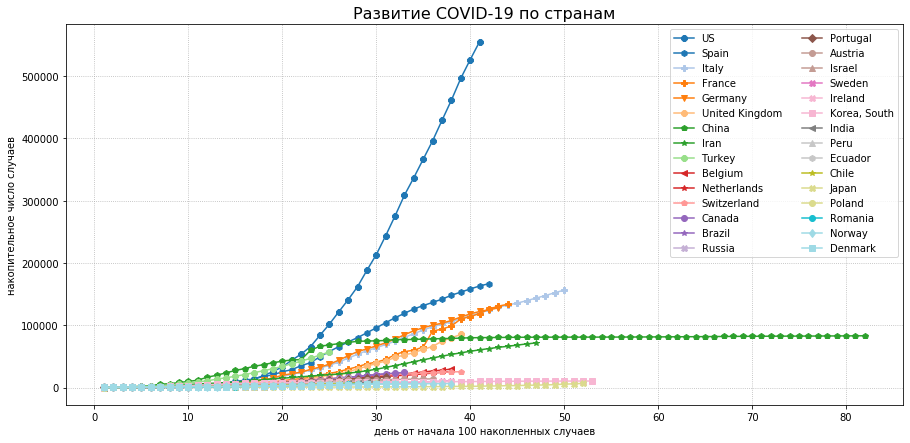

In [8]:
from matplotlib import markers as mrk

countries = df.groupby('Country/Region')['cases'].max().sort_values(ascending=False).head(30).index
markers = np.random.choice(mrk.MarkerStyle.filled_markers, len(countries), replace=True)
color_map = plt.cm.get_cmap('tab20', len(countries))

plt.figure(figsize=(15,7))

for i, country in enumerate(countries):
    q = (df['day_count_by_country'] > 0)&(df['Country/Region']==country)
    plt.plot(df[q]['day_count_by_country'], df[q]['cases'], marker=markers[i], color=color_map(i))
plt.legend(countries, ncol=2)
plt.xlabel('день от начала 100 накопленных случаев')
plt.ylabel('накопительное число случаев')
plt.title('Развитие COVID-19 по странам', fontsize=16)
plt.grid(True, linestyle=':')
plt.show()

# Приближение данных по России разными кривыми

In [9]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [10]:
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c 

def quadr_func(l, a, b, c):
    return [a * (x ** 2) + b * x + c for x in l ]

def three_func(l, a, b, c, d):
    return [a * (x ** 3) + b * (x ** 2) + c * x + d for x in l ]

def line_func(x, a, c):
    return a * x + c

In [11]:
popt_10_04 = np.array([ 2.69131033e+02,  1.53006781e-01, -3.13311354e+02])
popt_10_04_finland = np.array([ 7.84151657e+02,  5.11667840e-02, -6.81403907e+02])
popt_10_04_cheh = np.array([ 3.20418882e+03,  3.80639582e-02, -3.43241525e+03])

27


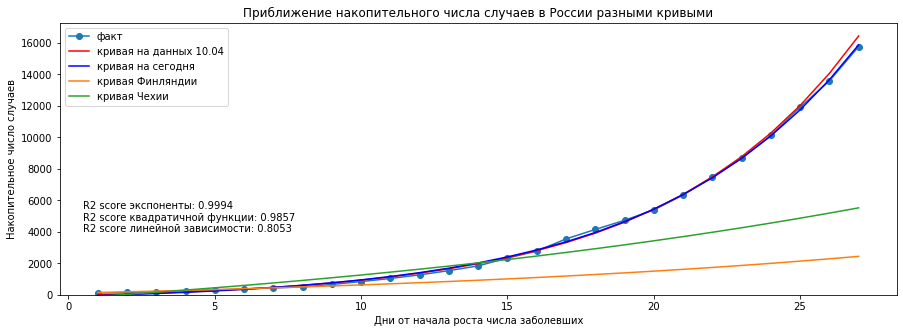

In [12]:
q = (df['day_count_by_country'] > 0)&(df['Country/Region']=='Russia')
print(len(df[q]))
ydata_dayly = df[q]['cases_by_day']
ydata = df[q]['cases']

xdata = range(1, len(ydata)+1)

# приближение накопительного прироста разными кривыми
exp_popt, pcov = curve_fit(exp_func, 
                       xdata,
                       ydata)
quadr_popt, pcov = curve_fit(quadr_func, 
                       xdata,
                       ydata)
line_popt, pcov = curve_fit(line_func, 
                       xdata,
                       ydata)

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))

plt.plot(xdata, ydata, label='факт', marker='o')

plt.plot(xdata, exp_func(xdata, *popt_10_04), 'r-',
         label='кривая на данных 10.04')
plt.plot(xdata, exp_func(xdata, *exp_popt), 'b-',
         label='кривая на сегодня')
plt.plot(xdata, exp_func(xdata, *popt_10_04_finland), 
         label='кривая Финляндии')
plt.plot(xdata, exp_func(xdata, *popt_10_04_cheh), 
         label='кривая Чехии')

#plt.plot(xdata, quadr_func(xdata, *quadr_popt), 'g-',
#         label='%5.3f * x ^ 2 + %5.3f * x + %5.3f' % tuple(quadr_popt))

#plt.plot(xdata, line_func(xdata, *line_popt), 'b-',
#         label='%5.3f * x + %5.3f' % tuple(line_popt))

plt.legend()
plt.ylabel('Накопительное число случаев')
plt.xlabel('Дни от начала роста числа заболевших')
plt.title('Приближение накопительного числа случаев в России разными кривыми')
plt.ylim(0)

r2_scores = [r2_score(ydata, exp_func(xdata, *exp_popt)),
             r2_score(ydata, quadr_func(xdata, *quadr_popt)),
             r2_score(ydata, line_func(xdata, *line_popt))]

text = '''R2 score экспоненты: {:0.4f}
R2 score квадратичной функции: {:0.4f}
R2 score линейной зависимости: {:0.4f}'''.format(*r2_scores)

plt.text(0.5, 4000, text)
plt.show()


50


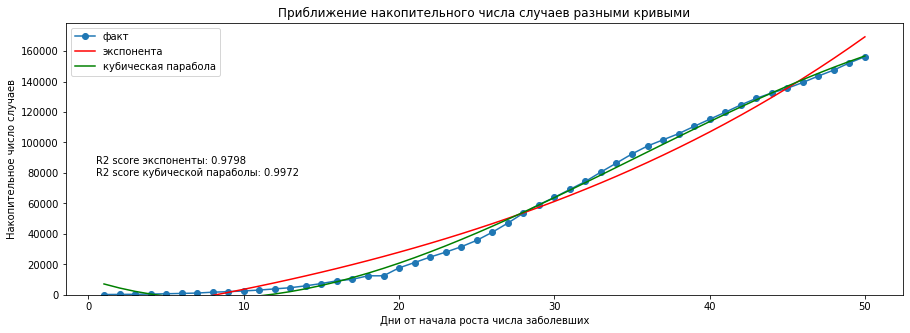

In [13]:
q = (df['day_count_by_country'] > 0)&(df['Country/Region']=='Italy')
print(len(df[q]))
ydata_dayly = df[q]['cases_by_day']
ydata = df[q]['cases']

xdata = range(1, len(ydata)+1)

# приближение накопительного прироста разными кривыми
exp_popt, pcov = curve_fit(exp_func, 
                       xdata,
                       ydata)
three_popt, pcov = curve_fit(three_func, 
                       xdata,
                       ydata)

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))

plt.plot(xdata, ydata, label='факт', marker='o')

plt.plot(xdata, exp_func(xdata, *exp_popt), 'r-',
         label='экспонента')

plt.plot(xdata, three_func(xdata, *three_popt), 'g-', label='кубическая парабола')

plt.legend()
plt.ylabel('Накопительное число случаев')
plt.xlabel('Дни от начала роста числа заболевших')
plt.title('Приближение накопительного числа случаев разными кривыми')
plt.ylim(0)

r2_scores = [r2_score(ydata, exp_func(xdata, *exp_popt)),
             r2_score(ydata, three_func(xdata, *three_popt))]

text = '''R2 score экспоненты: {:0.4f}
R2 score кубической параболы: {:0.4f}'''.format(*r2_scores)

plt.text(0.5, ydata.max()/2, text)
plt.show()


# Графики разных стран

In [14]:
df['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [15]:
def plot_country_data(df, country_name, start_date, event_dict={}, country_name_for_legend=None, log=False):
    if country_name_for_legend is None:
        country_name_for_legend = country_name
        
    tmp = df[df['Country/Region']==country_name].set_index('date')
    
    fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
    plt.xticks(rotation=60)

    ax1.plot(tmp['cases'], color='grey', marker='o', linewidth=2, markersize=8)
    for date, event in event_dict.items():
        height = tmp.loc[pd.to_datetime('03-10-2020'), 'cases'] + tmp['cases'].max()
        plt.text(date, 
                 tmp[tmp.index==date]['cases'][0]+height/50, 
                 event, 
                 fontsize=10, 
                 horizontalalignment='center',
                 rotation=60)
        ax1.vlines(date, 0, 
                   tmp[tmp.index==date]['cases'][0]+height/32, 
                   linestyle=':')

    if log == True: ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.plot(tmp['deaths'], color='firebrick', marker='*', linestyle='--', markersize=10)

    ax2.bar(x=tmp.index, height=tmp['cases_by_day'], color='red', alpha=0.5)

    if log == True: ax2.set_yscale('log')

    title = '''График числа выявленных случаев, смертей в {} {}
    (дата обновления: {:%d.%m.%Y})
    '''.format(country_name_for_legend, 
               ''.join(['(логарифмическая шкала)' if log else '']),
               tmp.index.max())

    ax1.set_xlim(start_date)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    ax1.set_ylim(0)
    plt.title(title, fontsize=14)
    ax1.legend(['накопительное число случаев'], loc='upper left')
    ax2.legend([ 'накопительный график смертей', 'выявлено случаев в день'], 
                   loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))
    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.set_ylabel('накопительное число случаев')
    ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')

    plt.show()

In [16]:
df.columns

Index(['Country/Region', 'date', 'cases', 'cases_by_day', 'deaths',
       'deaths_by_day', 'recovered', 'recovered_by_day', 'cases_next_day',
       'cases_previous_day', 'day_count_by_country'],
      dtype='object')

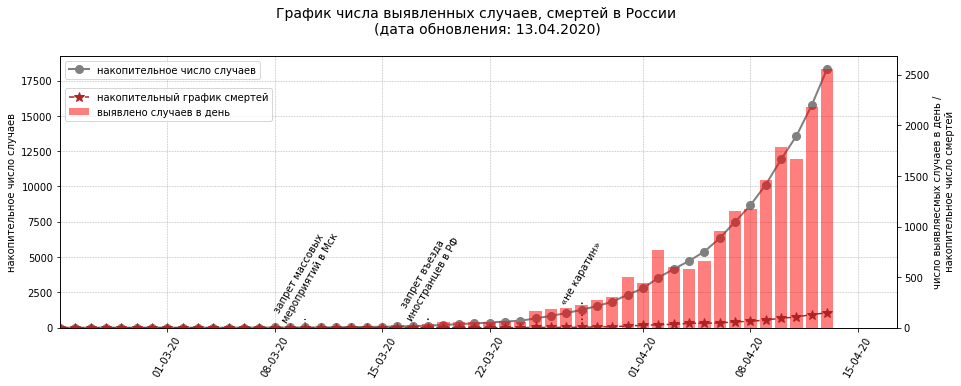

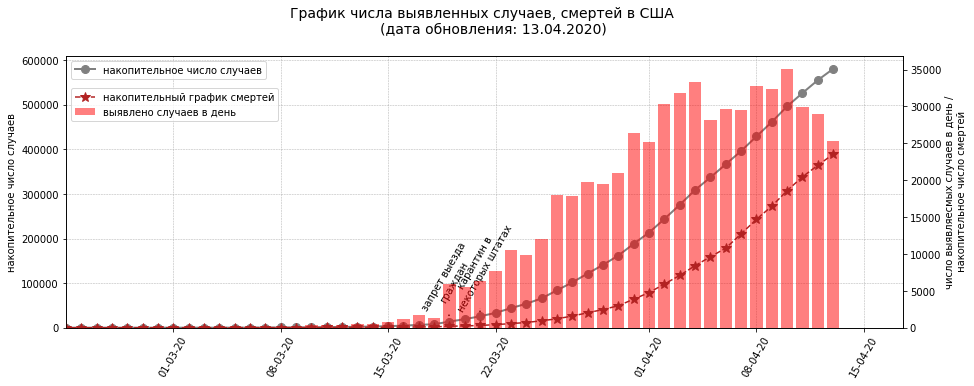

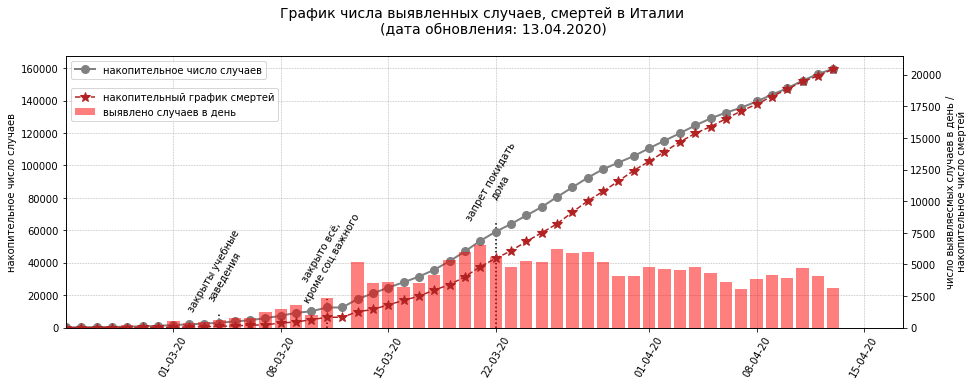

In [17]:
start_date = pd.to_datetime('02-23-2020')

plot_country_data(df, 'Russia', start_date,
                 event_dict = {pd.to_datetime('03-10-2020'): 'запрет массовых \nмероприятий в Мск',
                               pd.to_datetime('03-18-2020'): 'запрет въезда\nиностранцев в РФ',
                               pd.to_datetime('03-28-2020'): '«не каратин»'},
                 country_name_for_legend='России')

plot_country_data(df, 'US', start_date,
                 event_dict = {pd.to_datetime('03-19-2020'): 'запрет выезда\nграждан',
                               pd.to_datetime('03-21-2020'): 'карантин в\nнекоторых штатах'},
                 country_name_for_legend='США')

plot_country_data(df, 'Italy', start_date,
                 event_dict = {pd.to_datetime('03-04-2020'): 'закрыты учебные\nзаведения',
                               pd.to_datetime('03-11-2020'): 'закрыто всё,\nкроме соц.важного',
                               pd.to_datetime('03-22-2020'): 'запрет покидать\nдома',},
                 country_name_for_legend='Италии')

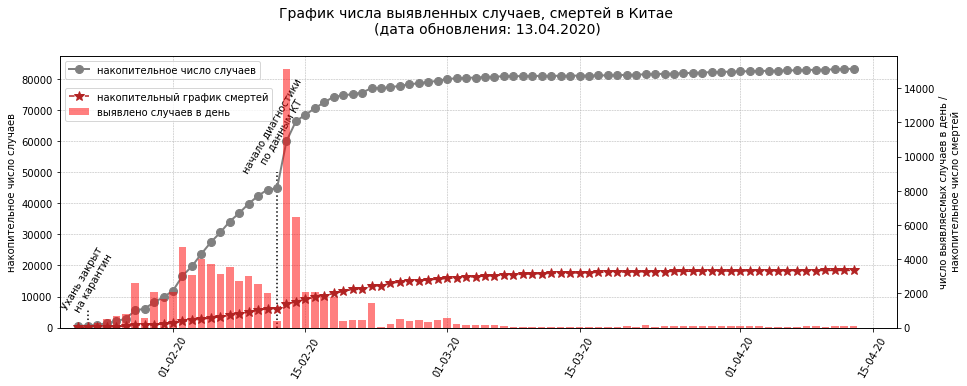

In [18]:
plot_country_data(df, 'China', pd.to_datetime('01-20-2020'),
                 event_dict = {pd.to_datetime('01-23-2020'): 'Ухань закрыт\n на карантин',
                               pd.to_datetime('02-12-2020'): 'начало диагностики\nпо данным КТ'},
                 country_name_for_legend='Китае')

# Корреляция выписываемости и смертности

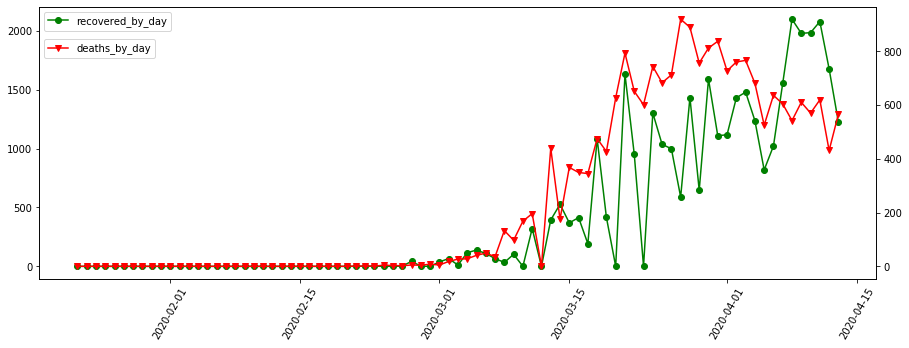

In [19]:
tmp = df[df['Country/Region']=='Italy']

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)
ax1.plot(tmp['date'], tmp['recovered_by_day'], color='green', marker='o')

ax2 = ax1.twinx()
ax2.plot(tmp['date'], tmp['deaths_by_day'], color='red', marker='v')

ax1.legend(['recovered_by_day'], loc='upper left')
ax2.legend(['deaths_by_day'], loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))

plt.show()

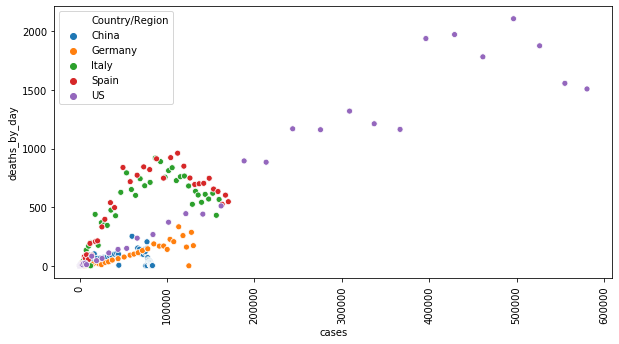

In [20]:
tmp = df[df['Country/Region'].isin(['Italy', 'China', 'Germany', 'Spain', 'US'])]

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

sns.scatterplot(data=tmp, x='cases', y='deaths_by_day', hue='Country/Region')
plt.xticks(rotation=90)
plt.show()